# Shallow ReLU nets as Linear Splines

In [1]:
import sys
import matplotlib as m

sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from absl import app
from absl import flags

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_lattice as tfl

from dcc import AAV, Parameters
import numpy as np
import matplotlib.pyplot as plt

import patsy
from scipy.interpolate import BSpline

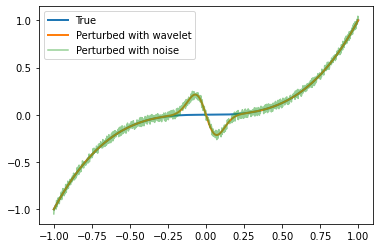

In [109]:
n_points = 1000
x_low = -1
x_high = 1
x = np.linspace(-1, 1, n_points, dtype='float32')
y_true = np.power(x, 3)
fig, ax = plt.subplots()
ax.plot(x, y_true, linewidth=2.0)
ax.plot(x, y_wave, linewidth=2.0)
ax.plot(x, y_perturbed, alpha=0.5)
ax.legend(['True', 'Perturbed with wavelet', 'Perturbed with noise'])

We will investigate a single hidden layer layer with arbitrary number of neurons with ReLU activation function. Hence, our net approximates $$\hat{y} : \mathbb{R} \rightarrow \mathbb{R}$$.

The output of the first layer neuron is given as:
$$ z_i = \max(0, w_0^{(1)} x + b_i ^ {(1)})$$

which gets combined in the output layer to produce

$$ y = \sum_i^n w_i^{(2)}z_i + b^{(2)}$$.

It is clear that $z_i$ is a relu of an affine transformation of x -> the node is where this transformation is equal to zero

$$x = -\frac{b_i^{(1)}}{w_i^{(1)}} $$.

The total number of nots will be smaller than the number of units in the first layer as nodes can coincide (theoretically).

In [130]:
inputs = tf.keras.Input(shape=(1,))
first_layer = keras.layers.Dense(6, activation='relu', use_bias=True)(inputs)
second_layer = keras.layers.Dense(1, use_bias=True, activation='linear')(first_layer)
model = tf.keras.Model(inputs=inputs, outputs=second_layer, name="combined")
model.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')

In [131]:
model.fit(x, y_true, epochs=500, verbose = 0, shuffle=True)

[WARNING] [2020-12-17 16:14:16,536] [tensorflow] - 9 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001A417AE6E58> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


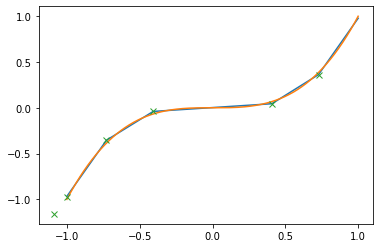

In [132]:
y_hat = model(x)

plt.plot(x, y_hat)
plt.plot(x, y_true)

roots = (-model.trainable_variables[1] / model.trainable_variables[0]).numpy()

plt.plot(roots.flatten(), model.predict_on_batch(roots.flatten()[:, None]).flatten(), 'x')

In [34]:
model.trainable_variables[0]

<tf.Variable 'dense_7/kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[ 0.9493095 ,  0.48270166,  1.06419   , -1.3481503 ]],
      dtype=float32)>

In [39]:
roots = (-model.trainable_variables[1] / model.trainable_variables[0]).numpy()

In [44]:
roots

array([[ 0.59606177,  0.11841741,  0.305469  , -0.40374118]],
      dtype=float32)

In [46]:
model.predict_on_batch(roots.flatten()[:, None])

array([[ 0.21695116],
       [ 0.        ],
       [-0.01967423],
       [ 0.        ]], dtype=float32)